<table align="center" width=100%>
    <tr>
        <td width="40%">
            <img src="https://image.pushauction.com/0/0/3f22d1bc-e8c2-4e47-8b47-88d74d8e4f4c/cf170397-633b-4c85-baa8-87dca110cd46.jpg">
        </td>
        <td>
            <div align="center">
                <font color="black";size=500px>
                    <b>ANIME RECOMMENDATION SYSTEM
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

#**Problem Statement**

#**Data Dictionary**

**1) anime_data:**

`anime_id` - unique id identifying an anime.

`name` - full name of anime.

`genre` - comma separated list of genres for this anime.

`type` - movie, TV, OVA, etc.

`episodes` - how many episodes in this show. (1 if movie).

`rating` - average rating out of 10 for this anime.

`members` - number of community members that are in this anime's "group".

**2) rating_data:**

`user_id` - non identifiable randomly generated user id.

`anime_id` - the anime that this user has rated.

`rating` - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

#**Import Libraries**

In [5]:
# import 'Pandas' 
import pandas as pd 

# import 'Numpy' 
import numpy as np

# import subpackage of Matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# import 'Seaborn' 
import seaborn as sns

# to suppress warnings 
from warnings import filterwarnings
filterwarnings('ignore')

# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None
 
# to display the float values upto 6 decimal places     
pd.options.display.float_format = '{:.6f}'.format

from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from surprise import Reader, SVD, Dataset
from surprise.model_selection import cross_validate
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from mlxtend.frequent_patterns import apriori,association_rules
import re
import string

from apyori import apriori

##*Setting the Option for the Dataset*

In [6]:
# display all columns of the dataframe
pd.options.display.max_columns = None
# display all rows of the dataframe
pd.options.display.max_rows = None
# return an output value upto 6 decimals
pd.options.display.float_format = '{:.6f}'.format

##*Installing Missing Modules*

In [ ]:
# installing the kneed module 
!pip install kneed

In [ ]:
# installing the apyori module 
!pip install apyori

In [ ]:
#installing the surprise
!pip install scikit-surprise

#**Reading the Dataset**

##*Anime DataSet*

In [ ]:
anime=pd.read_csv('./anime.csv')
anime.head()

In [ ]:
anime.info()

##*Rating DataSet*

In [ ]:
rating=pd.read_csv('./rating.csv',sep=',')
rating.head()

In [ ]:
rating.info()

#**Exploratory Data Analysis(EDA)**


##***Preparing the Dataset***

###*Data Cleaning*

In [ ]:
anime['name'].unique()[3:10]

In [12]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)
    
    return text
    anime['name'] = anime['name'].apply(text_cleaning)

In [13]:
anime['name'] = anime['name'].apply(text_cleaning)

In [ ]:
anime['name'].unique()[3:10]

In [ ]:
anime.episodes.unique()

In [16]:
anime.episodes.replace({'Unknown':np.nan},inplace=True)

###*Merging the Anime Dataset and Rating Dataset*

In [ ]:
anime_rating=pd.merge(anime,rating,on='anime_id')
anime_rating.head()

In [ ]:
anime_rating.rename(columns={'rating_x':'avg_rating','rating_y':'user_rating'},inplace=True)
anime_rating.head()

###*Data Info*

In [ ]:
anime_rating.info()

###*Data Dimension*

In [ ]:
anime.shape

In this dataset I have **12294** records across **7** features

In [ ]:
rating.shape

In this dataset I have **7813737** records across **3** features

In [ ]:
anime_rating.shape

In this dataset I have **7813737** records across **9** features

###*Data Type*

In [ ]:
anime_rating.dtypes

There are `4 objects`, `1 float` and `4 int` data types attributes.

As anime_id and user_id are unique values I need to convert it into `object` data type.

In [24]:
anime_rating['anime_id']=anime_rating.anime_id.astype('object')
anime_rating['user_id']=anime_rating.user_id.astype('object')

In [ ]:
anime_rating.dtypes

Now there are 6 `objects`, 2 `int` and 1 `float` attributes.

###*Missing Values*

In [26]:
missing_value = pd.DataFrame({
    'Missing Value': anime_rating.isnull().sum(),
    'Percentage': (anime_rating.isnull().sum() / len(anime_rating))*100
})

In [ ]:
missing_value.sort_values(by='Percentage', ascending=False)

There are few missing values in `genre`,`episodes`,`avg_rating` and `type`.

In [ ]:
anime.isnull().sum()

There are few missing values in `genre`,`episodes`,`avg_rating` and `type`.

In [29]:
# I can't replace the nan values with mean or median as it's unique for each movie
# So I will drop the null values rows
anime_rating.dropna(inplace=True)
anime.dropna(inplace=True)

In [ ]:
anime_rating.isnull().sum()

In [ ]:
anime.isnull().sum()

Now, There are no null values in the dataset.

###*Duplicating Data*

In [ ]:
duplicate = anime_rating.duplicated(subset=['anime_id','user_id']).sum()
print('There are {} duplicated rows in the data'.format(duplicate))

In [ ]:
duplicate = anime.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

####Getting rid of duplicate data

In [34]:
anime_rating.drop_duplicates(subset=['anime_id','user_id'],inplace=True)

####Checking for duplicate data after removal of duplicates

In [ ]:
duplicate = anime_rating.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

###*Indexing*

In [ ]:
anime_rating.shape

There are `7813604` records after removing missing values and duplicates.

In [ ]:
anime_rating.tail()

**The last 5 index values range from `7813722-7813726` but I have only `7813604` records thus the indexes need to be reset**

In [ ]:
anime_rating.reset_index(drop=True,inplace=True)
anime_rating.tail()

###*Final Dataset*

In [ ]:
anime_rating.shape

In [ ]:
anime_rating.head()

The final dataset has **7813604 records and 9 features with no missing and duplicate values**

###*Understanding the Dataset*

####Summary Statistics 

**Numeric Variables** 

In [ ]:
anime_rating.describe()

From the above table , I can infer:

1. The minimum avg_rating is `1.67` and the maximum avg_rating is `9.5`.

2. The number of members ranges from `29` to `1013917`.

3. Users rating ranges from `-1` to `10`. So, I will replace `-1` with NaN and drop the rows.

In [ ]:
anime_rating[anime_rating.user_rating==-1].shape

In [43]:
anime_rating.user_rating.replace({-1:np.nan},inplace=True)

In [ ]:
anime_rating.isnull().sum()


In [45]:
anime_rating.dropna(inplace=True)

In [ ]:
anime_rating.isnull().sum()

In [ ]:
anime_rating.shape

In [ ]:
anime_rating.describe()

**Interpretation:**

1. The minimum avg_rating is `2` and the maximum avg_rating is `9.37`.

2. The number of members ranges from `33` to `1013917`.

3. Users rating ranges from `1` to `10`.

**Categorical Variables**

In [ ]:
anime_rating.describe(include='object')

From the above table, I can infer:
    
1. There are `9892` unique anime_id and the most watched anime id is `1535` with frequency `34226`.

2. There are `9892` anime names and the most watched anime name is `Death Note`and `34226` users have been watched.

3. There are `3048` unique genres and `Comedy, School, Slice of Life` is the most repeated genre with frequency `49850`.

4. There are `6` unique values in type attribute and most of type is `TV` with frequency `4364293`.

5. Episodes specify the episode number of that particular anime.

6. There are `69600` users and the user with user_id `42635` is the top most user who have watched most of the animes.i.e. `3747` animes. 

####*Correlation*


In [ ]:
corr_matrix=anime_rating.corr()
corr_matrix

In [ ]:
plt.figure(figsize=(11,9))
sns.heatmap(corr_matrix, cmap='Purples', annot=True, fmt=".2f")
sns.set(font_scale=1.5)

**Inferences:**

Members and avg_rating have a positive relationship.i.e. **0.54**. Because as the number of members increase avg rating of the anime will also increase.

There is no Strong relationship betIen any attributes. 

####*Analyse Features*

In [52]:
nonull_anime=anime_rating.copy()
nonull_anime.dropna(inplace=True)
from collections import defaultdict

all_genres = defaultdict(int)

for genres in nonull_anime['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

In [ ]:
plt.figure(figsize=(15,10))
        
from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')

In [ ]:
anime_rating_count = anime_rating.groupby(by = ['name'])['user_rating'].count().reset_index()[['name', 'user_rating']]
anime_rating_count.rename(columns = {'user_rating': 'totalRatingCount'},inplace=True)
anime_rating_count.head()


In [ ]:
top10_animerating=anime_rating_count[['name', 'totalRatingCount']].sort_values(by = 'totalRatingCount',ascending = False).head(10)
plt.figure(figsize=(15,5))
ax=sns.barplot(x="name", y="totalRatingCount", data=top10_animerating, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on rating counts',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

From the graph I can infer:
    
Based on the user rating I can see that `Death Note` have been rated the most folloId by `Sword Art Online` and `Shingeki no Kyojin`.

**Top 10 animes based on community size**

In [ ]:
anime_rating_data=anime_rating.merge(anime_rating_count, left_on = 'name', right_on = 'name', how = 'left')
anime_rating_data.head()

In [ ]:
anime_rating_data.duplicated(subset=['name']).sum()

In [ ]:
anime1=anime_rating_data.drop_duplicates(subset=['name'])
anime1.head()

In [ ]:
top10_animemembers=anime1[['name', 'members']].sort_values(by = 'members',ascending = False).head(10)
plt.figure(figsize=(15,5))
ax=sns.barplot(x="name", y="members", data=top10_animemembers, palette="gnuplot2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on members',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('Community Size', fontsize = 20)

**Interpretation:**
    
`Death Note` as the huge community size folloId by `Shingeki no kyojin` and `Sword Art Online`.

**Distribution of rating**

In [ ]:
plt.figure(figsize = (15, 7))
plt.subplot(1,2,1)
anime_rating['avg_rating'].hist(bins=70)
plt.title("Rating of Ibsites")
plt.subplot(1,2,2)
anime_rating['user_rating'].hist(bins=70)
plt.title("Rating of users")

**Interpretation:**

Most of the ratings are spread betIen `6-10`.

The mode of the distribution is around `7.5-8.0`.

Both the distribution are left skeId.

**Percentage of users in each type**

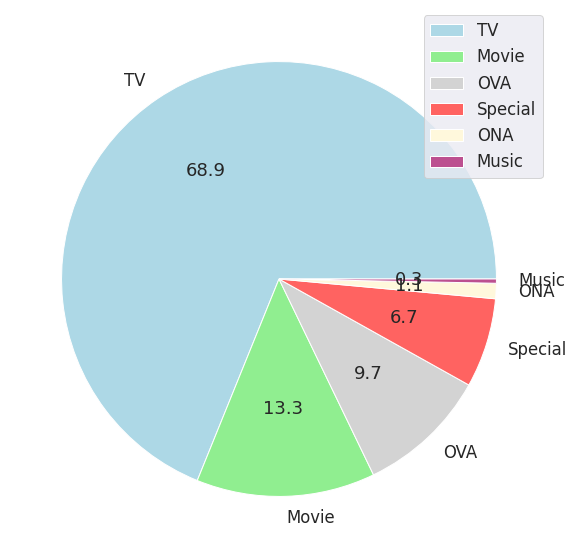

In [61]:
labels = anime_rating['type'].value_counts().index
values = anime_rating['type'].value_counts().values
plt.figure(figsize=(15,10))
plt.pie(x=values,labels=labels,autopct='%.1f',colors=['lightblue','lightgreen','lightgrey','#FF6361','Cornsilk','#BC5090'])
plt.legend()
plt.show()

**Interpretation:**

68.9% of the anime's Ire aired on TV follow Id by 13.3% through Movie.

9.7% of anime's are streamed as OVA which is greater than ONA(1.1%).

**Count of genres**

In [62]:
d1=pd.DataFrame(list(dict(all_genres).keys()),columns=['Genre'])

In [63]:
d2=pd.DataFrame(list(dict(all_genres).values()),columns=['count'])

In [ ]:
all_genres1=pd.concat(objs=(d1,d2),axis=1)
all_genres1.head()

In [ ]:
all_genres1=all_genres1.sort_values(by='count',ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(all_genres1['count'],all_genres1['Genre'])

From the plot I can infer that most of the animes watched belongs to comedy genre, next to that action and romance are most watched.

#**Data Preprocessing**

###*Categorical Encoding*

In [ ]:
anime.head()

In [ ]:
genres = anime['genre'].str.split(',', expand=True)
genres.head()

In [ ]:
# considering only first four genres columns 
genres = genres.iloc[:,:4]
genres.columns = ['genre1', 'genre2', 'genre3','genre4']
genres.head()

In [69]:
updated_rating=anime.copy()

In [ ]:
updated_rating = updated_rating.drop('genre', axis=1) 
updated_rating = pd.concat([updated_rating, genres], axis=1)
updated_rating.head()

In [ ]:
updated_rating['type'].unique()

In [72]:
updated_rating.episodes=updated_rating.episodes.astype('int')

In [73]:
df_cat = updated_rating.select_dtypes(np.object)
df_num = updated_rating.select_dtypes(np.number)

In [ ]:
df_dum = pd.get_dummies(df_cat[['type','genre1','genre2','genre3','genre4']])
df_dum.head()

###*Feature Scaling*

In [ ]:
df_num.head()

In [ ]:
df_num.set_index('anime_id',inplace=True)
df_num.head()

In [ ]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
df_num
df_scale = pd.DataFrame(ss.fit_transform(df_num),columns=df_num.columns)
df_scale.head()

In [ ]:
df_dum.reset_index(drop=True,inplace=True)

In [ ]:
full_df = pd.concat([df_scale,df_dum],axis=1)
full_df.head()

In [ ]:
full_df.shape

#**Clustering**

In [ ]:
ssd = []
sscore = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=4)
    kmeans.fit(full_df)
    ssd.append(kmeans.inertia_)
    ss = silhouette_score(full_df, kmeans.labels_)
    print ("For {} clusters the silhouette score is {})".format(k, ss))
    sscore.append(ss)

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(2,10), ssd, 'r')
ax.set_xlabel('No. Clusters')
ax.set_ylabel('SSD')

From the above graph I can infer that for `K = 4`, there is an elbow in the plot. 
Before this elbow point, the SSD is decreasing rapidly and after `K = 4`, the SSD is decreasing slowly.

In [ ]:
new_clusters = KMeans(n_clusters = 4, random_state = 10)

new_clusters.fit(full_df)

updated_rating['Cluster'] = new_clusters.labels_
updated_rating.head()

In [ ]:
updated_rating.Cluster.value_counts()

In [ ]:
sns.countplot(data= updated_rating, x = 'Cluster')
plt.title('Size of Cluster', fontsize = 15)
plt.xlabel('Clusters', fontsize = 15)
plt.ylabel('Number of Animes', fontsize = 15)
plt.show()

In [ ]:
# plot the lmplot to visualize the clusters
# pass the different markers to display the points in each cluster with different shapes
# the 'hue' parameter returns colors for each cluster
sns.lmplot(x = 'rating', y = 'members', data = updated_rating, hue = 'Cluster', fit_reg = False, size = 5)

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('K-means Clustering (for K=4)', fontsize = 15)
plt.ylabel('Community Size', fontsize = 15)
plt.xlabel('Rating', fontsize = 15)

# display the plot
plt.show()

#**Dimensionality Reduction**

###*PCA (Principal Component Analysis)*

In [ ]:
anime_rating.shape

In [ ]:
# Considering first 5000 users
sel_data= anime_rating[anime_rating.user_id <= 5000]
sel_data.head()

In [ ]:
sel_data.shape

In [ ]:
# calculating the frequency based on the user id and anime names
user_anime = pd.crosstab(sel_data['user_id'], sel_data['name'])
user_anime.head()

In [ ]:
user_anime.shape

In [ ]:
# initially considering 2000 components
pca = PCA(n_components=2000)
pca.fit(user_anime)

In [ ]:
#visualizing PCA components with cumulative scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()


From the above graph I can see that from the principle components 1500 the variance is almost 1.

In [ ]:
pca = PCA(n_components=1500)
pca.fit(user_anime)

pca_samples = pca.transform(user_anime)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

In [ ]:
ps = pd.DataFrame(pca_samples)
ps.head()

###*Clustering after dimension reduction*

In [ ]:
new_clusters = KMeans(n_clusters = 3, random_state = 4)

# fit the model
new_clusters.fit(ps)

# append the cluster label for each point in the dataframe 'df_cust'
user_anime['Cluster'] = new_clusters.labels_


In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(range(2,10), ssd, 'r')
ax.set_xlabel('No. Clusters')
ax.set_ylabel('SSD')

From the above plot I can see the elbow point is at `3`.

In [ ]:
user_anime.head()

In [ ]:
user_anime.Cluster.value_counts()

In [ ]:
# describing cluster 0
cluster0 = user_anime[user_anime['Cluster']==0].drop('Cluster',axis=1).mean()

In [ ]:
cluster0.sort_values(ascending=False)[0:15]

In [ ]:
# describe cluster 1
cluster1 = user_anime[user_anime['Cluster']==1].drop('Cluster',axis=1).mean()

In [ ]:
cluster1.sort_values(ascending=False)[0:15]

In [ ]:
def cluster_plot(data, nclusters):
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    X = data.copy()

    km = KMeans(n_clusters=nclusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)


    # Visualize it:
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=km.labels_.astype(float))
    
    # plot the centroids
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', label='centroids')
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

In [ ]:
cluster_plot(ps, 3)

#**Recommendation system**

###*Popularity Based recommendation system*

In [ ]:
anime_rating_data.head()

In [ ]:
rating1=anime_rating_data[['anime_id','name','genre','avg_rating','totalRatingCount']]
rating1.drop_duplicates(subset=['anime_id'],inplace=True)
rating1.reset_index(drop=True,inplace=True)

In [ ]:
rating1.shape

In [ ]:
# mean rating across all the animes
C = rating1['avg_rating'].mean()
# animes having total rate count greater than 85%
m = rating1['totalRatingCount'].quantile(0.85)
print('m: ', m, 'C: ', C)

In [ ]:
def Iighted_rating(x, m=m, C=C):
    v = x['totalRatingCount']
    R = x['avg_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# animes having total rate count greater than 85% is considered into lists_animes
lists_animes =rating1.copy().loc[rating1['totalRatingCount'] >= m]
lists_animes.shape

In [ ]:
# Define a new feature 'score' and calculate its value with `Iighted_rating()`
lists_animes['score'] = lists_animes.apply(Iighted_rating, axis=1)

In [ ]:
lists_animes.head()

In [ ]:
#Sort movies based on score calculated above
lists_animes = lists_animes.sort_values('score', ascending=False)

#Print the top 10 movies
lists_animes[['name', 'totalRatingCount', 'avg_rating', 'score']].head(10)

In [ ]:
pop=lists_animes[['name', 'totalRatingCount', 'avg_rating', 'score']].head(10)
plt.figure(figsize=(15,10))
sns.barplot(pop['score'],pop['name'])
plt.title('Anime')
plt.xlabel('Popularity Score')
plt.show()

The above plot shows top `10 animes` which can be recommended based on trend.

###*Content based Recommendation System*

In [ ]:
data=anime.copy()
# considering the anime content
data['describe']=data['genre']+data['type']+data['episodes']
data['describe'].fillna(' ')
data.head()

,anime_id,name,genre,type,episodes,rating,members,describe
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.370000,200630,"Drama, Romance, School, SupernaturalMovie1"
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.260000,793665,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.250000,114262,"Action, Comedy, Historical, Parody, Samurai, S..."
3,9253,SteinsGate,"Sci-Fi, Thriller",TV,24,9.170000,673572,"Sci-Fi, ThrillerTV24"
4,9969,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.160000,151266,"Action, Comedy, Historical, Parody, Samurai, S..."


In [ ]:
data.drop_duplicates(subset=['name'],inplace=True)

In [ ]:
data.shape

(11806, 8)

In [ ]:
data.reset_index(drop=True,inplace=True)

In [ ]:
tf = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
tf_matrix = tf.fit_transform(data['describe'])
tf_matrix.shape

(11806, 5383)

In [ ]:
simil = linear_kernel(tf_matrix, tf_matrix)
simil.shape

(11806, 11806)

In [ ]:
id=data['anime_id'].values
simil = pd.DataFrame(simil, index=id, columns=id)
simil.columns = data['name']
simil['anime_name'] = data['name'].values

In [ ]:
simil.head()

In [ ]:
if([simil.anime_name.value_counts()>1]==True):
    print('There are duplicates rows')
else:
    print('There are no duplicate rows')

In [ ]:
# user defined function to recommend animes based on genre and type
def content_rec(name):
    idx = simil[simil['anime_name']==name]
    idx = idx.drop('anime_name', axis=1).T
    idx.columns = ['similar_val']
    idx = idx.sort_values(by='similar_val', ascending=False)
    return idx

In [ ]:
content_rec('Kimi no Na wa').head(10)

The above output recommend the similar animes which is almost same genre and type.

###*Collaberative filtering Recommendation System*

In [ ]:
anime_rating.shape

In [ ]:
anime_rating.duplicated(subset=['user_id','name']).sum()

In [ ]:
anime_rating1=anime_rating.copy()
anime_rating1.drop_duplicates(subset=['user_id','name'],inplace=True)

In [ ]:
anime_rating1.reset_index(drop=True,inplace=True)

In [ ]:
counts = anime_rating1['user_id'].value_counts()
anime_feature = anime_rating1[anime_rating1['user_id'].isin(counts[counts >= 500].index)]

In [ ]:
anime_feature.shape

In [ ]:
# user-item matrix
anime_rating_pivot = anime_feature.pivot(index='name', columns='user_id', values='user_rating')
anime_rating_pivot = anime_rating_pivot.fillna(0)
anime_rating_pivot.head()

In [ ]:
anime_rating_pivot.shape

###*Memory based Recommendation System (Similar anime)*

####Using KNN

In [ ]:
model_knn = NearestNeighbors(metric='cosine')
model_knn.fit(anime_rating_pivot)

NearestNeighbors(metric='cosine')

In [ ]:
distances, indices = model_knn.kneighbors(anime_rating_pivot, n_neighbors=6)

In [ ]:
recommend = pd.DataFrame(indices, columns=['anime0', 'anime1', 'anime2', 'anime3', 'anime4', 'anime5'])
recommend.head()

In [ ]:
recommend2 = recommend.copy()
for i in range(0, 6):
    animes = pd.DataFrame(anime_rating_pivot.index).reset_index()
    animes = animes.rename(columns={'index':f'anime{i}'})
    recommend2 = pd.merge(recommend2, animes, on=[f'anime{i}'], how='left')
    recommend2 = recommend2.drop(f'anime{i}', axis=1)
    recommend2 = recommend2.rename(columns={'name':f'anime{i}'})

In [ ]:
recommend2.head(10)

The above table shows the 5 similar animes for each anime.

####Using SVD

In [ ]:
anime_rating_pivot.shape

(4579, 47)

In [ ]:
#initially I will consider 1300 components
svd = TruncatedSVD(random_state=4, n_components=1300)
svd.fit(anime_rating_pivot)

In [ ]:
#visualizing svd components with cumulative scree plot 
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.show()

From the above graph I can see that the svd component `1000` it's variance is almost `1`.

In [ ]:
# Now I will consider only 1000 components
svd = TruncatedSVD(random_state=4, n_components=1000)
svd.fit(anime_rating_pivot)

In [ ]:
anime_rating_svd = svd.fit_transform(anime_rating_pivot)

In [ ]:
anime_rating_svd.shape

In [ ]:
corr = np.corrcoef(anime_rating_svd)
corr.shape

In [ ]:
corr

In [ ]:
anime_title = anime_rating_pivot.index
anime_list = list(anime_title)

anime_Vampire_Knight = anime_list.index('Vampire Knight')
anime_Vampire_Knight

In [ ]:
corr_anime_Vampire_Knight = corr[anime_Vampire_Knight]

In [ ]:
anime_title[(corr_anime_Vampire_Knight)>0.65]

###*Model based Recommendation System(Surprise)*

In [ ]:
anime_rating_data.head()

In [ ]:
counts = anime_rating_data['user_id'].value_counts()
# considering only users who have watched more than 1500 animes
anime_feature1 = anime_rating_data[anime_rating_data['user_id'].isin(counts[counts >= 1500].index)]

In [ ]:
anime_feature1.shape

In [ ]:
anime_feature1.user_rating.value_counts()


In [ ]:
reader = Reader(rating_scale=(1.0,10.0))
data1 = Dataset.load_from_df(anime_feature[['user_id', 'name', 'user_rating']], reader)

In [ ]:
svd = SVD()
cross_validate(svd, data1, measures=['rmse'], cv=3, return_train_measures=True)

In [ ]:
trainset = data1.build_full_trainset()
svd.fit(trainset)

In [ ]:
items = anime_feature['name'].unique()
test = [[13954.0, iid, 8] for iid in items]
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

In [ ]:
pred.sort_values(by='est', ascending=False).head(10)

The above output are the predicted rating that a user may give for the respective animes. 

###*Hybrid Recommendation System*

In [ ]:
md2 = anime[['anime_id', 'name']]

In [ ]:
simil.head(2)

In [ ]:
# pre defined function to predict the user rating of similar animes where I pass the anime name along with the user id as parameters
def hybrid_rec(ttl, userid):
    idx = simil[simil['anime_name']==ttl]
    idx = idx.drop('anime_name', axis=1).T
    idx.columns = ['values']
    idx['id'] = simil.index
    # considering only top 25 similar animes
    idx = idx.sort_values(by='values', ascending=False).head(25)
    items = idx['id'].unique()
    test = [[userid, iid, 8] for iid in items]
    predictions = svd.test(test)
    pred = pd.DataFrame(predictions)
    pred = pred.merge(md2, left_on='iid', right_on='anime_id')
    pred = pred.sort_values(by='est', ascending=False)
    return pred

In [ ]:
hybrid_rec('Death Note',13954.0)

This are top 25 animes similar to the `Death Note` and the estimated rating that the user `13954` will allocate.

###*Association analysis*

In [ ]:
anime.head()

In [ ]:
rating.head()

####By Type

In [ ]:
def get_ar_type(type):
    type_ul=[]
    grouped = rating.groupby("user_id")
    set_type = set(anime[anime["type"] == type]["anime_id"].values)
    print(type+' :',len(set_type))
    
    
    for i in rating['user_id'].unique():
        g = grouped.get_group(i)
        r = g[g['rating']>=6]
        set_trans = set(r['anime_id'].values)
        anime_type = list(set_type.intersection(set_trans)) 
        if len(anime_type)>1:
            type_ul.append(anime_type)
            
            
    association_rules = apriori(type_ul, min_support=0.15, min_confidence=0.4,min_lift=1)
    association_results = list(association_rules)
    
    
    Result=pd.DataFrame(columns=['Antecedents','Consequents','Support','Confidence','Lift'])
    for item in association_results:
        pair = item[2]
        for i in pair:
            items = str([x for x in i[0]])
            if i[3]!=1:
                Result=Result.append({'Antecedents':str([anime[anime['anime_id']==x].reset_index().loc[0,'name'] for x in i[0]]),'Consequents':str([anime[anime['anime_id']==x].reset_index().loc[0,'name'] for x in i[1]]),'Support':item[1],'Confidence':i[2],'Lift':i[3]},ignore_index=True)
    Result_ar=Result.sort_values(by='Lift',ascending=False)
    Result_ar=Result_ar.reset_index(drop=True)
    return Result_ar


In [ ]:
get_ar_type('Movie').head(10)

As for Rule 0 : If a user has Watched and liked `Howl no Ugoku Shiro` and `Sen to Chihiro no Kamikakushi` there is `57%` confidence with `0.15` support he/she will like `Tonari no Totoro`<br>
As for Rule 7 : If a user has Watched and liked `Mononoke Hime` there is `59%` confidence with `0.18` support he/she will like `Sen to Chihiro no Kamikakushi`and `Howl no Ugoku Shiro`

In [ ]:
Result_tv=get_ar_type('TV')

In [ ]:
def find_anime_ar(name,result):
    temp=result.copy()
    temp['Antecedents']=temp['Antecedents'].apply(lambda x:x if name in x else 'different')
    temp=temp[temp['Antecedents']!='different']
    temp=temp.reset_index(drop=True)
    return temp 

In [ ]:
find_anime_ar('Death Note',Result_tv).head(10)

As for Rule 0 : If a user has Watched and liked `Code Geass 1st season` and `Death Note` there is `87.7%` confidence with `0.235` support he/she will like `Code Geass 2nd season`<br>
As for Rule 5 : If a user has Watched and liked `Shingeki no Kyojin` and `Death Note` there is `68%` confidence with `0.17` support he/she will like `Sword Art Online`

####By Genre 

In [ ]:
anime.reset_index(drop=True,inplace=True)

In [ ]:
def get_ar_genre(genre):
    genre_ul=[]
    set_genre=set()
    for i in range(len(anime)):
        str_genre = anime.loc[i, 'genre']
        if pd.isnull(str_genre):
            continue
        A = str_genre.strip().split(", ")
        for j in A:
            if j==genre:
                set_genre.add(anime.loc[i,"anime_id"])
    
    
    grouped = rating.groupby("user_id")
    print(genre+' :',len(set_genre))
    
    for i in rating['user_id'].unique():
        g = grouped.get_group(i)
        r = g[g['rating']>=6]
        set_trans = set(r['anime_id'].values)
        anime_genre = list(set_genre.intersection(set_trans)) 
        if len(anime_genre)>1:
            genre_ul.append(anime_genre)
            
            
    association_rules = apriori(genre_ul, min_support=0.15, min_confidence=0.5,min_lift=1)
    association_results = list(association_rules)
    
    
    Result=pd.DataFrame(columns=['Antecedents','Consequents','Support','Confidence','Lift'])
    for item in association_results:
        pair = item[2]
        for i in pair:
            items = str([x for x in i[0]])
            if i[3]!=1:
                Result=Result.append({'Antecedents':str([anime[anime['anime_id']==x].reset_index().loc[0,'name'] for x in i[0]]),'Consequents':str([anime[anime['anime_id']==x].reset_index().loc[0,'name'] for x in i[1]]),'Support':item[1],'Confidence':i[2],'Lift':i[3]},ignore_index=True)
    Result_ar=Result.sort_values(by='Lift',ascending=False)
    Result_ar=Result_ar.reset_index(drop=True)
    return Result_ar

In [ ]:
get_ar_genre('Comedy').head(10)

As for Rule 0 : If a user has Watched and liked `Clannad` there is `61%` confidence with `0.18` support he/she will like `Toradora`<br>
As for Rule 2 : If a user has Watched and liked `No Game No Life` there is `65%` confidence with `0.16` support he/she will like `Angel Beats`

In [ ]:
result_action=get_ar_genre('Action')

In [ ]:
result_action.head()

In [ ]:
find_anime_ar('Fullmetal Alchemist',result_action).head(10)

As for Rule 4 : If a user has Watched and liked `Fullmetal Alchemist` there is `59%` confidence with `0.2` support he/she will like `Fullmetal Alchemist  Brotherhood`<br>
As for Rule 9 : If a user has Watched and liked `Fullmetal Alchemist Brotherhood` there is `60%` confidence with `0.21` support he/she will like `Shingeki no Kyojin`

#**Conclusion**

- Recommender systems open new opportunities of retrieving personalized information on the Ib.I have built various       recommender models each one performs Ill under circumstances.

- For a new user popularity based and content based recommender works Ill later based on user activities collaborative based and association recommenders performs better.

- A  better  anime  recommendation  system is when I consider user  watch  history.So collaborative based filtering (model-based) recommendation model would be best for recommend animes to the users.

#**Reference**

https://www.researchgate.net/publication/342690182_Collaborative_Recommendation_System_in_Users_of_Anime_Films

https://iopscience.iop.org/article/10.1088/1742-6596/1566/1/012057/pdf

https://towardsdatascience.com/building-a-recommendation-system-for-anime-566f864acea8

https://arxiv.org/pdf/1709.01584.pdf

https://medium.com/analytics-vidhya/anime-recommendation-engine-content-collaborative-filtering-c6e69be29d29